In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, types
import pyspark.sql.functions as F
from  pyspark.sql.functions import col

spark = (
    SparkSession.builder.config("spark.sql.debug.maxToStringFields", 100)
    .appName("reviews")
    .getOrCreate()
)

# data_filepath = "../data/cleaned_steam_reviews/game_id={70,240,420,620}"
# data_filepath = "../data/cleaned_steam_reviews/game_id=2870"
top_10_data_filepath = "../data/cleaned_steam_reviews/game_id={578080,271590,359550,105600,4000,252490,252950,218620,945360,292030}"
data_filepath = "../data/cleaned_steam_reviews"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 19:45:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/28 19:45:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/11/28 19:45:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
steam_reviews = spark.read.parquet(data_filepath)

In [3]:
top_10_steam_reviews = spark.read.parquet(top_10_data_filepath)

In [4]:
steam_games_review_counts = spark.read.csv("./review_counts.csv", header=True)

In [5]:
def get_review_over_playtime(steam_reviews, range_size_hours = 5, review_range_cap_hours = 1000, group_by_app_id = False):
    # No change
    range_size = range_size_hours * 60
    review_range_cap = (review_range_cap_hours * 60) // range_size

    review_over_playtime = steam_reviews.select("app_id", "app_name", "recommended", "author_playtime_at_review") \
                                    .where(col("author_playtime_at_review").isNotNull() & col("recommended").isNotNull()) \
                                    .withColumn("positive", F.when(col("recommended") == True, 1).otherwise(0)) \
                                    .withColumn("playtime_at_review_range", F.floor(col("author_playtime_at_review") / range_size)) \
                                    .where(col("playtime_at_review_range") < review_range_cap)
    
    if group_by_app_id:
        review_over_playtime = review_over_playtime.groupBy("app_id", "playtime_at_review_range") \
                                                    .agg( \
                                                        F.count(col("*")).alias("num_of_reviews"), \
                                                        F.sum(col("positive")).alias("positive") \
                                                    ) \
                                                    .withColumn("positive_percentage", col("positive") / col("num_of_reviews") * 100) \
                                                    .orderBy("app_id", "playtime_at_review_range")
    else:
        review_over_playtime = review_over_playtime.groupBy("playtime_at_review_range") \
                                                    .agg( \
                                                        F.count(col("*")).alias("num_of_reviews"), \
                                                        F.sum(col("positive")).alias("positive") \
                                                    ) \
                                                    .withColumn("positive_percentage", col("positive") / col("num_of_reviews") * 100) \
                                                    .orderBy("playtime_at_review_range")

    review_over_playtime = review_over_playtime.withColumn("playtime_at_review_range", col("playtime_at_review_range") * range_size_hours)

    return review_over_playtime

## Recommended VS Playtime for all games

<AxesSubplot:title={'center':'Positive Review % Over Playtime (Range Size: 5h, Max: 1000h)'}, xlabel='Playtime at Review (hours)', ylabel='Positive Review Percentage'>

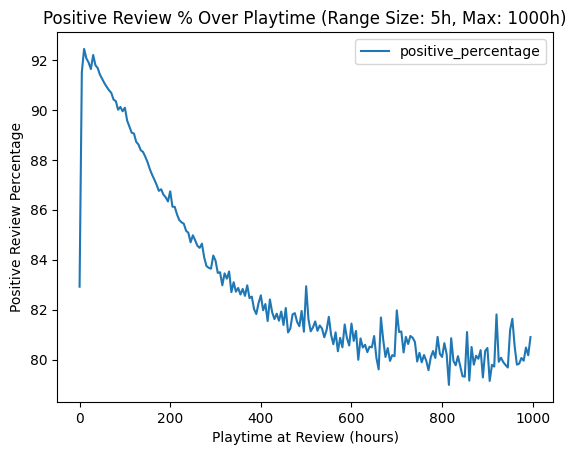

In [7]:
range_size_hours = 5
review_range_cap_hours = 1000

review_over_playtime = get_review_over_playtime(steam_reviews, range_size_hours=range_size_hours, review_range_cap_hours=review_range_cap_hours)
review_over_playtime.toPandas().plot.line(x='playtime_at_review_range',
                                          y='positive_percentage',
                                          title=f"Positive Review % Over Playtime (Range Size: {range_size_hours}h, Max: {review_range_cap_hours}h)",
                                          xlabel="Playtime at Review (hours)",
                                          ylabel="Positive Review Percentage"
                                          )

<AxesSubplot:title={'center':'Recommended % Over Playtime (Range Size: 10h, Max: 2000h)'}, xlabel='Playtime at Review (hours)', ylabel='Recommended %'>

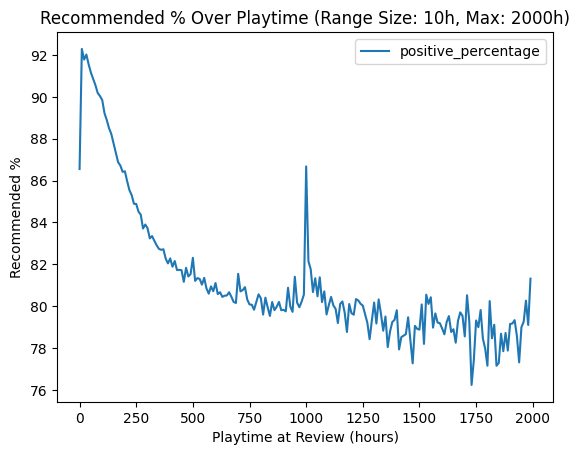

In [63]:
range_size_hours = 10
review_range_cap_hours = 2000

review_over_playtime = get_review_over_playtime(steam_reviews, range_size_hours=range_size_hours, review_range_cap_hours=review_range_cap_hours)
review_over_playtime.toPandas().plot.line(x='playtime_at_review_range',
                                          y='positive_percentage',
                                          title=f"Recommended % Over Playtime (Range Size: {range_size_hours}h, Max: {review_range_cap_hours}h)",
                                          xlabel="Playtime at Review (hours)",
                                          ylabel="Recommended %"
                                          )

<AxesSubplot:title={'center':'Recommended % Over Playtime (Range Size: 1h, Max: 200h)'}, xlabel='Playtime at Review (hours)', ylabel='Recommended %'>

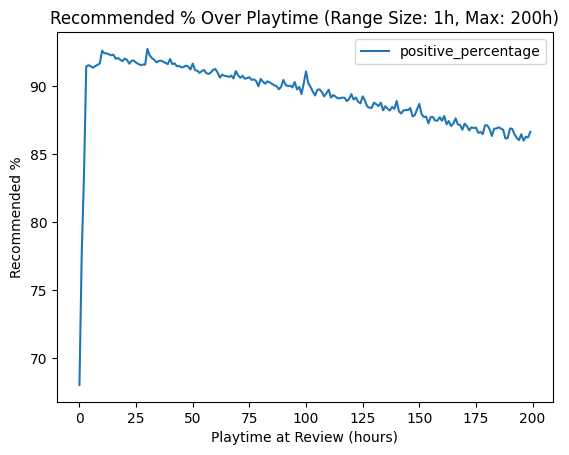

In [64]:
range_size_hours = 1
review_range_cap_hours = 200

review_over_playtime = get_review_over_playtime(steam_reviews, range_size_hours=range_size_hours, review_range_cap_hours=review_range_cap_hours)
review_over_playtime.toPandas().plot.line(x='playtime_at_review_range',
                                          y='positive_percentage',
                                          title=f"Recommended % Over Playtime (Range Size: {range_size_hours}h, Max: {review_range_cap_hours}h)",
                                          xlabel="Playtime at Review (hours)",
                                          ylabel="Recommended %"
                                          )

<AxesSubplot:title={'center':'Recommended % Over Playtime (Range Size: 1h, Max: 10h)'}, xlabel='Playtime at Review (hours)', ylabel='Recommended %'>

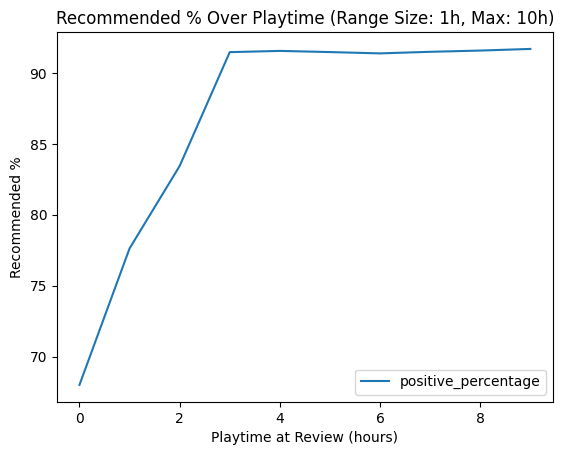

In [65]:
range_size_hours = 1
review_range_cap_hours = 10

review_over_playtime = get_review_over_playtime(steam_reviews, range_size_hours=range_size_hours, review_range_cap_hours=review_range_cap_hours)
review_over_playtime.toPandas().plot.line(x='playtime_at_review_range',
                                          y='positive_percentage',
                                          title=f"Recommended % Over Playtime (Range Size: {range_size_hours}h, Max: {review_range_cap_hours}h)",
                                          xlabel="Playtime at Review (hours)",
                                          ylabel="Recommended %"
                                          )

## Recommended VS Playtime for top reviewed games (more than 400,000) and lowest reviewed games (lower than 10,000)

- No Significant conclusion
    - Top reviewed games = same trend as above
    - Lowest reviewed games = fluctutating after inital increase, and no overall decrease afterwards (maybe due to insufficient datapoints)

In [76]:
large_steam_games_review_counts = steam_games_review_counts.where(col("review_count") > 400000).select("app_id")

large_steam_reviews = steam_reviews.join(large_steam_games_review_counts, steam_reviews["app_id"] == large_steam_games_review_counts["app_id"], "inner").drop(large_steam_games_review_counts["app_id"])
large_steam_reviews.show(10)

+------+--------------------+---------+--------+------------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------+
|app_id|            app_name|review_id|language|                              review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|game_id|
+------+--------------------+---------+--------+------------------------------------+-----------------+-----------------+-----------+-------------+-------

<AxesSubplot:title={'center':'Recommended % Over Playtime (Range Size: 5h, Max: 1000h)'}, xlabel='Playtime at Review (hours)', ylabel='Recommended %'>

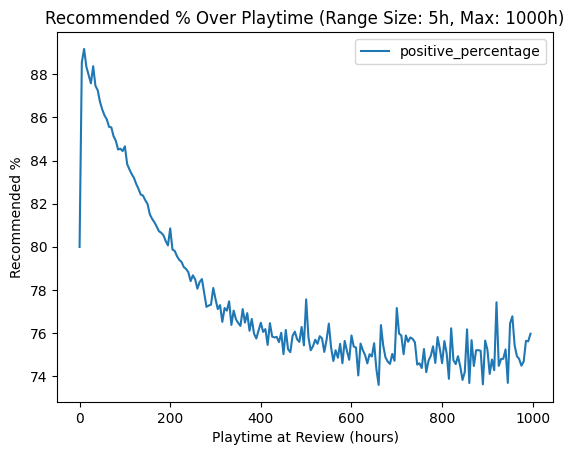

In [77]:
range_size_hours = 5
review_range_cap_hours = 1000

review_over_playtime = get_review_over_playtime(large_steam_reviews, range_size_hours=range_size_hours, review_range_cap_hours=review_range_cap_hours)
review_over_playtime.toPandas().plot.line(x='playtime_at_review_range',
                                          y='positive_percentage',
                                          title=f"Recommended % Over Playtime (Range Size: {range_size_hours}h, Max: {review_range_cap_hours}h)",
                                          xlabel="Playtime at Review (hours)",
                                          ylabel="Recommended %"
                                          )

In [74]:
small_steam_games_review_counts = steam_games_review_counts.where(col("review_count") < 10000).select("app_id")

small_steam_reviews = steam_reviews.join(small_steam_games_review_counts, steam_reviews["app_id"] == small_steam_games_review_counts["app_id"], "inner").drop(small_steam_games_review_counts["app_id"])
small_steam_reviews.show(10)

+------+--------------------+---------+--------+-------------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+--------------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+-------+
|app_id|            app_name|review_id|language|                               review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|      author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|game_id|
+------+--------------------+---------+--------+-------------------------------------+-----------------+-----------------+-----------+------------

<AxesSubplot:title={'center':'Recommended % Over Playtime (Range Size: 5h, Max: 1000h)'}, xlabel='Playtime at Review (hours)', ylabel='Recommended %'>

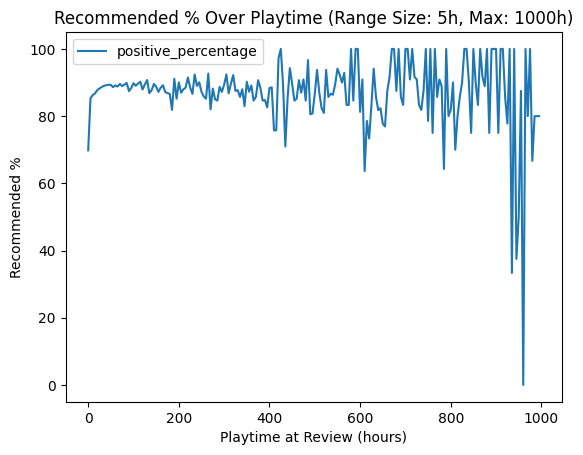

In [80]:
range_size_hours = 5
review_range_cap_hours = 1000

review_over_playtime = get_review_over_playtime(small_steam_reviews, range_size_hours=range_size_hours, review_range_cap_hours=review_range_cap_hours)
review_over_playtime.toPandas().plot.line(x='playtime_at_review_range',
                                          y='positive_percentage',
                                          title=f"Recommended % Over Playtime (Range Size: {range_size_hours}h, Max: {review_range_cap_hours}h)",
                                          xlabel="Playtime at Review (hours)",
                                          ylabel="Recommended %"
                                          )